# NYSE ML Project Machine Learning Analysis
This notebook will training and testing three different machine learning models with and without PCA. The three algorithms used are Support Vector Classifier (SVC), K nearest neighbors, and random forest decision trees.

## Setup

In [1]:
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.frame import DataFrame
from pandas.core.series import Series
from matplotlib import ticker
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from IPython.display import display
from joblib import dump, load

%matplotlib inline

In [2]:
cleaned_df = pd.read_csv('./outputs/data/final-model.csv')

Create DataFrame for Results

In [3]:
time_df = pd.DataFrame(columns=['Model', 'Time to Train', 'Time to Predict', 'F-score', 'Precision', 'Recall', 'Accuracy'])

Create Function to Train, Predict, and Populate Results DataFrame

In [4]:
# Function to train predict, and populate scores in the results dictionary
def train_predict(model:str,
                  grid_obj:GridSearchCV ,
                  x_train: DataFrame,
                  y_train: DataFrame,
                  x_test: Series,
                  y_test: Series) -> dict: 
    '''
    inputs:
        - model: the name of the model
        - grid_obj: the grid search object to train and predict
        - x_train: features training set
        - y_train: income training set
        - x_test: features testing set
        - y_test: income testing set
    '''
    
    results = {}
    results['Model'] = model
    
    start = timeit.default_timer()
    grid_fit = grid_obj.fit(x_train, y_train)
    end = timeit.default_timer()
    learner = grid_fit.best_estimator_
    
    results['Time to Train'] = end - start
        
    start = timeit.default_timer()
    predictions_test = learner.predict(x_test)
    end = timeit.default_timer()
    
    results['Time to Predict'] = end - start
            
    results['F-score'] = fbeta_score(y_test, predictions_test, beta=0.5, average=None)[0]
        
    results['Precision'] = precision_score(y_test, predictions_test, average=None)[0]
    
    results['Recall'] = recall_score(y_test, predictions_test, average=None)[0]
        
    results['Accuracy'] = accuracy_score(y_test, predictions_test)
       
    return results, learner

### Handling Data Types

In [5]:
dtype_counts = cleaned_df.dtypes.value_counts()
print(dtype_counts)

float64    231
object       3
int64        1
bool         1
Name: count, dtype: int64


Convert Data Types

In [6]:
cleaned_df['GICS Sector'] = cleaned_df['GICS Sector'].astype('category')
cleaned_df['GICS Sub Industry'] = cleaned_df['GICS Sub Industry'].astype('category')

# Confirm all data types are correct
dtype_counts = cleaned_df.dtypes.value_counts()
print(dtype_counts)

float64     231
int64         1
object        1
bool          1
category      1
category      1
Name: count, dtype: int64


## Split Into Train and Test

In [7]:
# Add dummy encoding for categorical variables
cleaned_df = pd.get_dummies(cleaned_df, columns=cleaned_df.select_dtypes(include=['category']).columns)
cleaned_df.shape

(435, 362)

In [8]:
top_performing_raw = cleaned_df['75th Percentile']
features_raw = cleaned_df.drop(['75th Percentile'], axis=1)
symbols_raw = features_raw['Symbol']
features_raw = features_raw.drop(['Symbol'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(features_raw,
                                                    top_performing_raw,
                                                    test_size=0.2,
                                                    random_state=42)

print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Standardize Values

In [9]:
scalar = MinMaxScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)

In [10]:
# Export scalar
dump(scalar, './outputs/models/scalar.joblib')

['./outputs/models/scalar.joblib']

### Naive Predictor Performance

In [11]:
true_positives = np.sum(top_performing_raw)
false_positives = top_performing_raw.count() - true_positives
true_negatives = 0
false_negatives = 0

accuracy = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
fscore = (1 + pow(0.5,2)) * ((precision * recall) / ((pow(0.5,2) * precision) + recall))

new_row = {
    'Model': 'Naive Predictor',
    'Time to Train': 0,
    'Time to Predict': 0,
    'F-score': fscore,
    'Precision': precision,
    'Recall': recall,
    'Accuracy': accuracy
}

time_df.loc[len(time_df.index)] = new_row
time_df.head(10)

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0,0,0.299838,0.255172,1.0,0.255172


### Train Models

#### Without PCA
##### SVC

In [12]:
svc_no_pca = SVC(random_state=42)

scorer = make_scorer(fbeta_score, beta=0.5, average='micro')
parameters = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
              'shrinking': [True, False],
              'probability': [True, False],
              'decision_function_shape': ['ovo', 'ovr']}

grid_obj = GridSearchCV(svc_no_pca, parameters, scoring=scorer)

results, svc_no_pca = train_predict('SVC Without PCA', grid_obj, x_train, y_train, x_test, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))

print(svc_no_pca.get_params())
dump(svc_no_pca, './outputs/models/svc_no_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.299838,0.255172,1.000000,0.255172
1,SVC Without PCA,2.565039,0.001396,0.800493,0.764706,0.984848,0.758621


{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


['./outputs/models/svc_no_pca.joblib']

##### K Nearest Neighbors

In [13]:
knn_no_pca = KNeighborsClassifier()

parameters = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30, 40, 50],
              'n_jobs': [-1]}
grid_obj = GridSearchCV(knn_no_pca, parameters, scoring=scorer)

results, knn_no_pca = train_predict('KNN Without PCA', grid_obj, x_train, y_train, x_test, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))
print(knn_no_pca.get_params())
dump(knn_no_pca, './outputs/models/knn_no_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.299838,0.255172,1.000000,0.255172
1,SVC Without PCA,2.565039,0.001396,0.800493,0.764706,0.984848,0.758621
2,KNN Without PCA,22.915663,0.012555,0.780423,0.756410,0.893939,0.701149


{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}


['./outputs/models/knn_no_pca.joblib']

##### Random Forest

In [14]:
rfc_no_pca = RandomForestClassifier(random_state=42)

parameters = {'bootstrap': [True, False],
              'n_estimators': [10, 25, 50, 75, 100], 
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2'],
              'n_jobs': [-1]}

grid_obj = GridSearchCV(rfc_no_pca, parameters, scoring=scorer)

results, rfc_no_pca = train_predict('RFC Without PCA', grid_obj, x_train, y_train, x_test, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))
print(rfc_no_pca.get_params())
dump(rfc_no_pca, './outputs/models/rfc_no_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.299838,0.255172,1.000000,0.255172
1,SVC Without PCA,2.565039,0.001396,0.800493,0.764706,0.984848,0.758621
2,KNN Without PCA,22.915663,0.012555,0.780423,0.756410,0.893939,0.701149
3,RFC Without PCA,17.790130,0.005661,0.794872,0.765432,0.939394,0.735632


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


['./outputs/models/rfc_no_pca.joblib']

#### With PCA
##### SVC

In [15]:
pca = PCA(random_state=42, n_components=100)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# Export PCA
dump(pca, './outputs/models/pca.joblib')

['./outputs/models/pca.joblib']

In [16]:
svc_pca = SVC(random_state=42)

parameters = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
              'shrinking': [True, False],
              'probability': [True, False],
              'decision_function_shape': ['ovo', 'ovr']}

grid_obj = GridSearchCV(svc_pca, parameters, scoring=scorer)

results, svc_pca = train_predict('SVC With PCA', grid_obj, x_train_pca, y_train, x_test_pca, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))

print(svc_pca.get_params())
dump(svc_pca, './outputs/models/svc_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.299838,0.255172,1.000000,0.255172
1,SVC Without PCA,2.565039,0.001396,0.800493,0.764706,0.984848,0.758621
2,KNN Without PCA,22.915663,0.012555,0.780423,0.756410,0.893939,0.701149
3,RFC Without PCA,17.790130,0.005661,0.794872,0.765432,0.939394,0.735632
4,SVC With PCA,1.638264,0.000793,0.792683,0.755814,0.984848,0.747126


{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


['./outputs/models/svc_pca.joblib']

##### K Nearest Neighbors

In [17]:
knn_pca = KNeighborsClassifier()

parameters = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30, 40, 50],
              'n_jobs': [-1]}
grid_obj = GridSearchCV(knn_pca, parameters, scoring=scorer)

results, knn_no_pca = train_predict('KNN With PCA', grid_obj, x_train_pca, y_train, x_test_pca, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))
print(knn_no_pca.get_params())
dump(knn_no_pca, './outputs/models/knn_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.299838,0.255172,1.000000,0.255172
1,SVC Without PCA,2.565039,0.001396,0.800493,0.764706,0.984848,0.758621
2,KNN Without PCA,22.915663,0.012555,0.780423,0.756410,0.893939,0.701149
3,RFC Without PCA,17.790130,0.005661,0.794872,0.765432,0.939394,0.735632
4,SVC With PCA,1.638264,0.000793,0.792683,0.755814,0.984848,0.747126
5,KNN With PCA,15.834222,0.008380,0.775401,0.753247,0.878788,0.689655


{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


['./outputs/models/knn_pca.joblib']

##### Random Forest

In [18]:
rfc_pca = RandomForestClassifier(random_state=42)

parameters = {'bootstrap': [True, False],
              'n_estimators': [10, 25, 50, 75, 100], 
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2'],
              'n_jobs': [-1]}

grid_obj = GridSearchCV(rfc_pca, parameters, scoring=scorer)

results, rfc_pca = train_predict('RFC With PCA', grid_obj, x_train_pca, y_train, x_test_pca, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))
print(rfc_pca.get_params())
dump(rfc_pca, './outputs/models/rfc_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.299838,0.255172,1.000000,0.255172
1,SVC Without PCA,2.565039,0.001396,0.800493,0.764706,0.984848,0.758621
2,KNN Without PCA,22.915663,0.012555,0.780423,0.756410,0.893939,0.701149
3,RFC Without PCA,17.790130,0.005661,0.794872,0.765432,0.939394,0.735632
4,SVC With PCA,1.638264,0.000793,0.792683,0.755814,0.984848,0.747126
5,KNN With PCA,15.834222,0.008380,0.775401,0.753247,0.878788,0.689655
6,RFC With PCA,17.054143,0.016245,0.770270,0.750000,0.863636,0.678161


{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


['./outputs/models/rfc_pca.joblib']

In [19]:
# save results to csv
time_df.to_csv('./outputs/data/model-performance.csv')

### Compare Models Performance

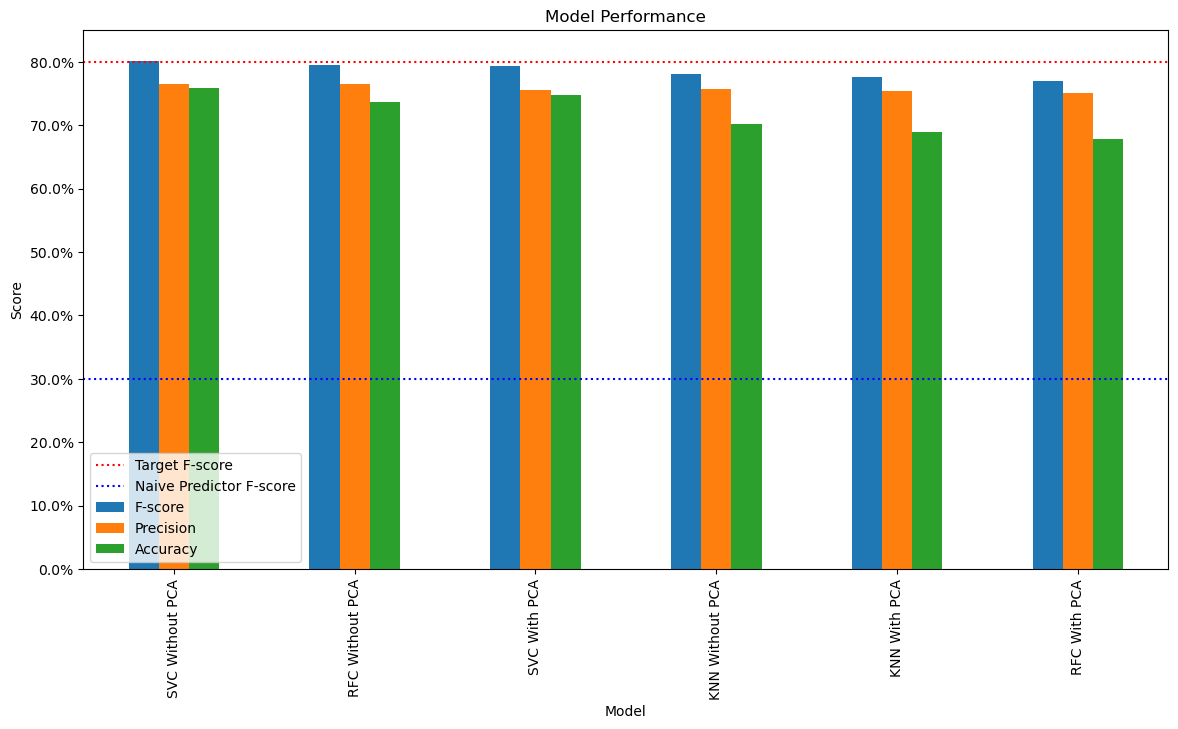

In [20]:
plt.figure(figsize=(14,7))
plt.title('Model Performance')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim((0,0.85))
plt.axhline(y=0.8, color='r', linestyle='dotted', label='Target F-score')
plt.axhline(y=time_df.iloc[0]['F-score'], color='b', linestyle='dotted', label='Naive Predictor F-score')
plt.legend()

# Use FuncFormatter to apply a lambda to the y-values
formatter = ticker.FuncFormatter(lambda y, pos: f'{round(y * 100, 0)}%')
plt.gca().yaxis.set_major_formatter(formatter)

time_df.iloc[range(1,len(time_df.index))].sort_values('F-score', ascending= False).plot.bar(x='Model', y=['F-score', 'Precision', 'Accuracy'], ax=plt.gca());


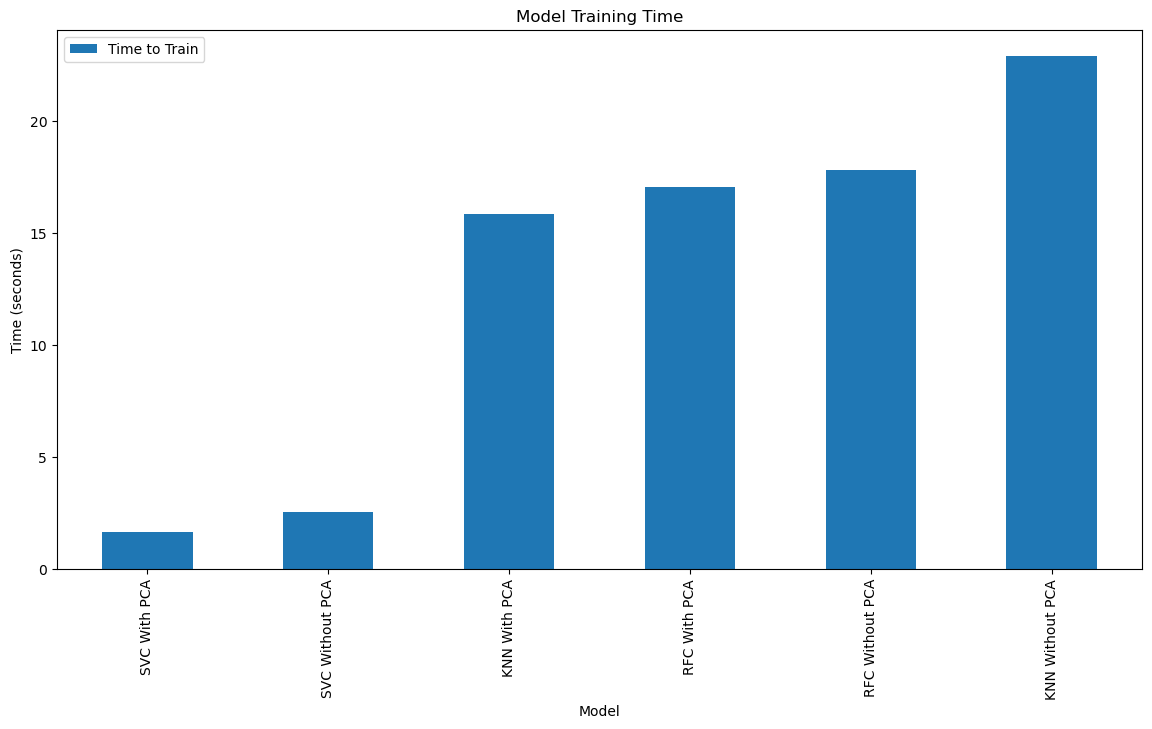

In [21]:
plt.figure(figsize=(14,7))
plt.title('Model Training Time')
plt.ylabel('Time (seconds)')
plt.xlabel('Model')

time_df.iloc[range(1,len(time_df.index))].sort_values('Time to Train', ascending= True).plot.bar(x='Model', y='Time to Train', ax=plt.gca());

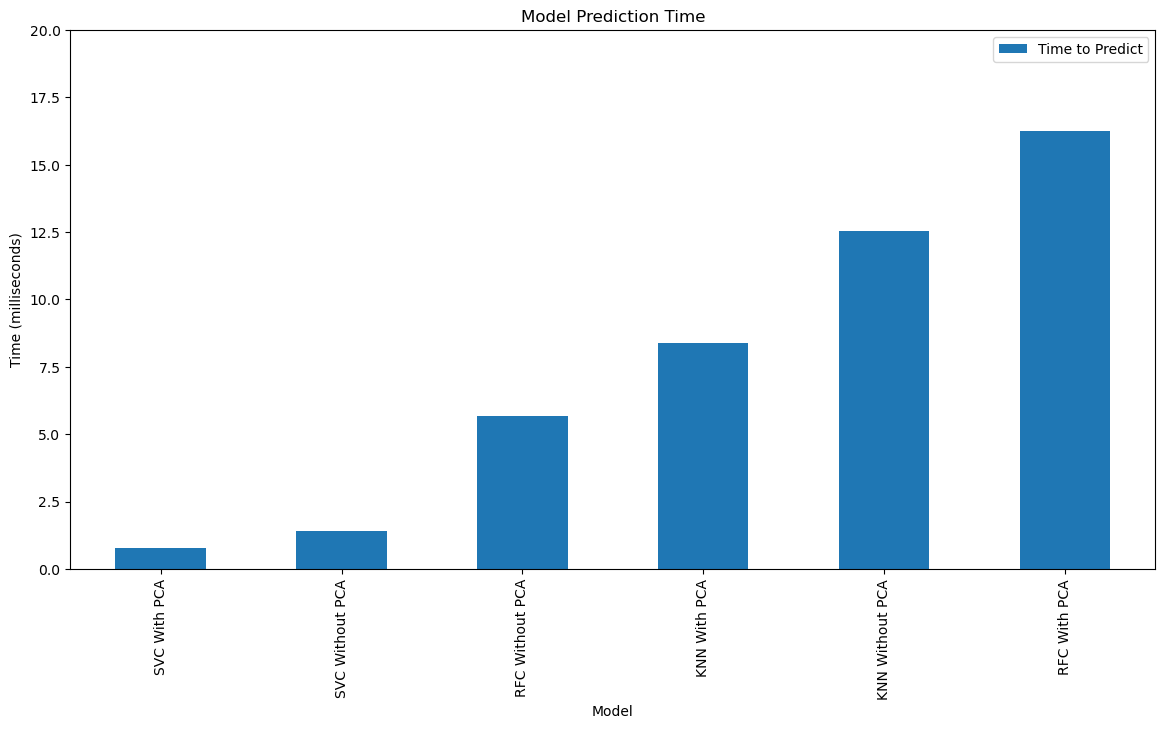

In [22]:
plt.figure(figsize=(14,7))
plt.title('Model Prediction Time')
plt.ylabel('Time (milliseconds)')
plt.xlabel('Model')
plt.ylim((0,0.02))

# Use FuncFormatter to apply a lambda to the y-values
formatter = ticker.FuncFormatter(lambda y, pos: f'{y * 1000}')
plt.gca().yaxis.set_major_formatter(formatter)

time_df.iloc[range(1,len(time_df.index))].sort_values('Time to Predict', ascending= True).plot.bar(x='Model', y='Time to Predict', ax=plt.gca());